# Combining the 2022 Election Forecasts

Combining 538 [forecasts](https://projects.fivethirtyeight.com/2022-election-forecast/senate/) for US House, US Senate, and Governor seats and Louis Jacobson's state legislative [ratings](https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/) into an index to find good places to focus in 2022. 

In [1]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# https://medium.com/@dustinmichels/three-handy-jupyter-notebook-snippets-dcb2f8ddc7db
import sys; sys.path.insert(0, '..')
from election_meta import models as m, scrape as s

In [2]:
# https://stackoverflow.com/questions/65996797
# from importlib import reload
# reload(s)
# reload(m)

# Power Sharing Model

In [3]:
state_pop = pd.read_csv('data/states/population.csv')
state_metadata = state_pop[['state', 'population']].copy()
state_converter = pd.read_csv('data/states/state_converter.csv')
state_metadata = state_metadata.merge(state_converter, on='state')
state_freq = pd.read_csv('data/states/election_frequencies.csv')

power = m.calculate_year_adjusted_seatpower(state_metadata, state_freq)
print(power.keys())
power['statehouse_power'].sort_values(
    by='potential_power', ascending=False
).head(10)

dict_keys(['statehouse_power', 'statesenate_power', 'governor_power', 'presidential_power', 'ussenate_power', 'ushouse_power'])


,state,population,state_abbr,fips,population_multiplier,election_frequency,branch,potential_power
4,California,39237836,CA,6,0.118224,2.0,statehouse,2.955602
41,Texas,29527941,TX,48,0.088968,2.0,statehouse,2.224201
8,Florida,21781128,FL,12,0.065627,2.0,statehouse,1.640670
30,New York,19835913,NY,36,0.059766,2.0,statehouse,1.494146
36,Pennsylvania,12964056,PA,42,0.039061,2.0,statehouse,0.976522
12,Illinois,12671469,IL,17,0.038179,2.0,statehouse,0.954482
19,Maryland,6165129,MD,24,0.018576,4.0,statehouse,0.928781
33,Ohio,11780017,OH,39,0.035493,2.0,statehouse,0.887333
9,Georgia,10799566,GA,13,0.032539,2.0,statehouse,0.813481
31,North Carolina,10551162,NC,37,0.031791,2.0,statehouse,0.794770


# US House

In [4]:
def process_538_legislature(dist, close_range, top, power_val):
    # Each party seatprob sums to 1, so just use one of them, assuming
    # no third parties.
    # hs_dist = hs_dist.eval('seatprob = seatprob_Dparty + seatprob_Rparty')

    # 5% margin around center
    low, high = close_range
    dist = dist.query('@low <= seatsheld <= @high')
    pr_close = dist['seatprob_Dparty'].sum()

    # Interesting, even though this isn't considered a tossup, 63.8% of probability distribution 
    # is in a close outcome. For tossup state legislatures, it's only 0.38. Hm.
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin', 'tipping'
    ]]
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()

    top['potential_power'] = power_val
    top['pr_close'] = pr_close
    top = top.eval('realized_power = potential_power*pr_close*tipping')
    # mean_netpartymargin is dem_twoparty_margin
    top = top.sort_values(by='realized_power', ascending=False)
    return top
    

In [5]:
five_data = s.get_538(
    save_loc='./data/fivethirtyeight/',
    archive_loc='./data/archive/'
)
# Only use _deluxe models:
for key, df in five_data.items(): 
    five_data[key] = df.query('expression == "_deluxe"')

Accessed: house_dist
Accessed: house_toplines
Accessed: senate_dist
Accessed: senate_toplines
Accessed: governor_toplines


In [6]:
hs_top = process_538_legislature(
    dist = five_data['house_dist'],
    close_range = [(435/2) - 0.025*435, (435/2) + 0.025*435],
    top = five_data['house_toplines'],
    power_val = power['ushouse_power']
)
hs_top['branch'] = 'ushouse'
hs_top.head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
38581,ushouse,IA-3,2022-09-04,-3.011803,5.757271,-11.67423,0.026950,IA,25.0,0.465925,0.313917
38516,ushouse,MI-10,2022-09-04,-4.896629,4.121452,-14.02906,0.025063,MI,25.0,0.465925,0.291931
38392,ushouse,OR-5,2022-09-04,-2.630020,6.541840,-11.75027,0.024913,OR,25.0,0.465925,0.290184
38477,ushouse,NC-13,2022-09-04,-1.431511,7.294456,-10.08764,0.024200,NC,25.0,0.465925,0.281885
38288,ushouse,WI-3,2022-09-04,-4.982727,4.107307,-14.09413,0.023825,WI,25.0,0.465925,0.277517
38452,ushouse,NJ-7,2022-09-04,-2.110771,7.368612,-11.67133,0.023537,NJ,25.0,0.465925,0.274168
38376,ushouse,PA-7,2022-09-04,-1.168869,7.686310,-10.04914,0.023325,PA,25.0,0.465925,0.271693
38634,ushouse,CO-8,2022-09-04,-1.792564,7.914083,-11.63315,0.022275,CO,25.0,0.465925,0.259462
38701,ushouse,AZ-2,2022-09-04,-3.015038,7.059753,-13.17424,0.021788,AZ,25.0,0.465925,0.253784
38448,ushouse,NM-2,2022-09-04,-1.585106,8.682308,-11.90642,0.021375,NM,25.0,0.465925,0.248979


In [7]:
hs_top['realized_power'].sum()

11.648125

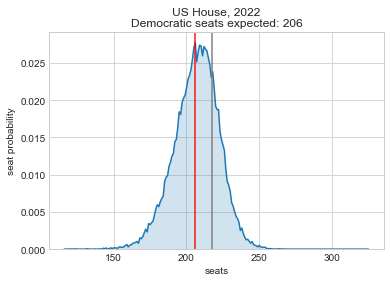

In [8]:
# hs_exp_seats = len(hs_top.query('mean_netpartymargin > 0'))
# Just find most probable seat count:
hs_exp_seats = five_data['house_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

hs_title = f'US House, 2022\nDemocratic seats expected: {hs_exp_seats}'
m.plot_seatprob(
    x = five_data['house_dist']['seatsheld'],
    y = five_data['house_dist']['seatprob_Dparty'],
    mean_outcome = hs_exp_seats,
    midpoint=217.5,
    title=hs_title,
    x_label='seats',
    y_label='seat probability',
    out='data/output/househist.png'
)

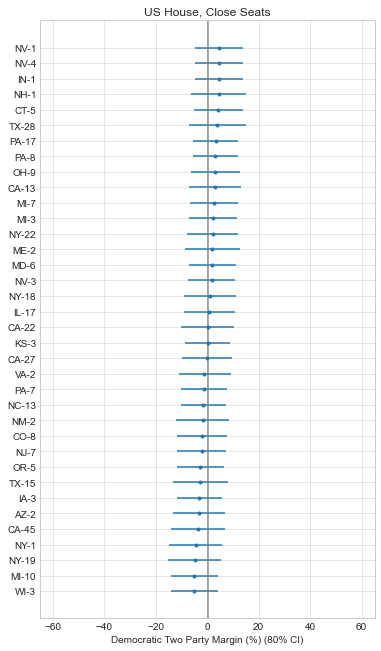

In [9]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
hsplot = hs_top.copy()
hsplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
hsplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
hsplot = hsplot.sort_values(by='mean_netpartymargin', ascending=True)
hsplot.reset_index(drop=True, inplace=True)
#hsplot = hsplot.loc[192:243]
hsplot = hsplot.query('-5 <= mean_netpartymargin <= 5')
m.seatplot(
    hsplot,
    x='mean_netpartymargin',
    y='district',
    title='US House, Close Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/houseseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# US Senate

In [10]:
sen_top = process_538_legislature(
    dist = five_data['senate_dist'],
    close_range = [50 - 2.5, 50 + 2.5],
    top = five_data['senate_toplines'],
    power_val = power['ussenate_power']
)
sen_top['branch'] = 'ussenate'
sen_top.head()

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
3106,ussenate,GA-S3,2022-09-04,0.774178,8.980309,-7.416113,0.154388,GA,25.0,0.641325,2.475314
3092,ussenate,NV-S3,2022-09-04,2.102226,11.383720,-7.155506,0.135763,NV,25.0,0.641325,2.176697
3080,ussenate,WI-S3,2022-09-04,-0.453033,8.839512,-9.724136,0.124262,WI,25.0,0.641325,1.992316
3111,ussenate,AZ-S3,2022-09-04,4.885197,14.116590,-4.307312,0.109125,AZ,25.0,0.641325,1.749615
3095,ussenate,NC-S3,2022-09-04,-2.307522,6.617327,-11.271270,0.101475,NC,25.0,0.641325,1.626961


In [11]:
sen_top['realized_power'].sum()

16.033125000000005

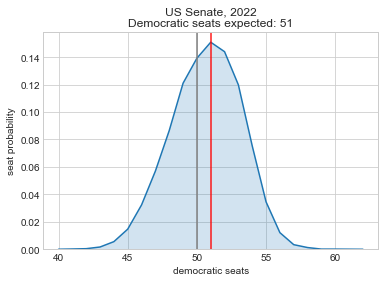

In [12]:
#sen_exp_seats = 36 + len(sen_top.query('mean_netpartymargin > 0')) # 36 seats not up
# Just find most probable seat count:
sen_exp_seats = five_data['senate_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

sen_title = f'US Senate, 2022\nDemocratic seats expected: {sen_exp_seats}'
m.plot_seatprob(
    x = five_data['senate_dist']['seatsheld'],
    y = five_data['senate_dist']['seatprob_Dparty'],
    mean_outcome = sen_exp_seats,
    midpoint=50,
    title=sen_title,
    x_label='democratic seats',
    y_label='seat probability',
    out='data/output/senatehist.png'
)

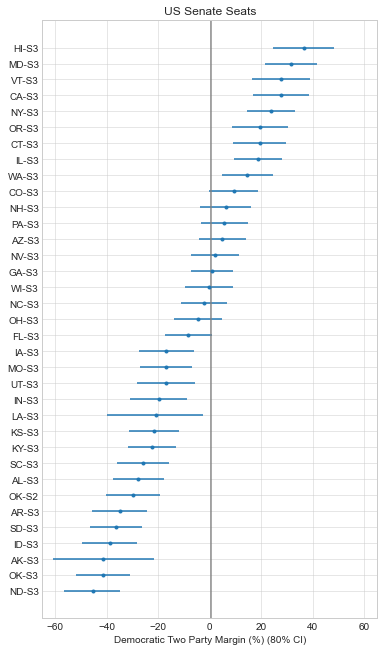

In [13]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
senplot = sen_top.copy()
senplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
senplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
senplot = senplot.sort_values(by='mean_netpartymargin', ascending=True)
senplot.reset_index(drop=True, inplace=True)
m.seatplot(
    senplot,
    x='mean_netpartymargin',
    y='district',
    title='US Senate Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/senateseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# Governors

In [14]:
# https://www.sciencedirect.com/topics/engineering/confidence-interval
# https://mathworld.wolfram.com/StandardDeviation.html
# Assuming normal, 80% CI = mean +- 1.282*SD
# So for WY governor:
# se = (53-38)/1.282
# se

In [15]:
# Instead of simulating, just integrate estimated normal distributions
def estimate_prclose(row):
    dist = stats.norm(
        loc=row['mean_netpartymargin'],
        scale=row['stdev']
    )
    # Integrate around central outcome, in this case 0 is tie
    pr_close = dist.cdf(2.5) - dist.cdf(-2.5)
    return pr_close

def process_538_governors(top, power):
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin'
    ]]
    # 'tipping', what is tipping in the context of Governors? Tip what?
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()
    
    # https://mathworld.wolfram.com/StandardDeviation.html
    # 80% CI is roughly 1.28 sigma
    top.eval('stdev = (p90_netpartymargin - mean_netpartymargin)/1.28155', inplace=True)
    top['pr_close'] = top.apply(estimate_prclose, axis=1)
    
    gov_pow = power[['state_abbr', 'potential_power']].copy()
    top = top.merge(gov_pow, on='state_abbr')
    top['pr_tip'] = 1
    top.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
    
    return top

In [16]:
gov_top = process_538_governors(five_data['governor_toplines'], power['governor_power'])
gov_top.sort_values(by='realized_power', ascending=False).head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,state_abbr,stdev,pr_close,potential_power,pr_tip,realized_power
27,governor,PA-G1,2022-09-04,6.622093,14.841460,-1.586126,PA,6.413614,0.182737,3.906086,1,0.713786
12,governor,AZ-G1,2022-09-04,0.473560,8.691755,-7.857000,AZ,6.412699,0.302569,2.192363,1,0.663340
18,governor,GA-G1,2022-09-04,-6.110477,2.185118,-14.376000,GA,6.473095,0.196775,3.253923,1,0.640290
8,governor,FL-G1,2022-09-04,-10.240470,-1.684393,-18.880300,FL,6.676351,0.094973,6.562681,1,0.623278
22,governor,TX-G1,2022-09-04,-12.125710,-3.203856,-21.106810,TX,6.961768,0.065559,8.896806,1,0.583266
16,governor,WI-G1,2022-09-04,2.964378,12.259250,-6.342659,WI,7.252836,0.248873,1.776444,1,0.442110
19,governor,MI-G1,2022-09-04,9.538979,18.238060,0.774240,MI,6.787937,0.111806,3.028322,1,0.338584
20,governor,OR-G1,2022-09-04,4.074329,14.107000,-5.910736,OR,7.828544,0.219797,1.279372,1,0.281201
32,governor,NV-G1,2022-09-04,2.243244,10.867170,-6.419352,NV,6.729293,0.274771,0.947288,1,0.260287
3,governor,KS-G1,2022-09-04,0.818996,9.645144,-8.061144,KS,6.887088,0.281483,0.884193,1,0.248885


In [17]:
gov_top['realized_power'].sum()

5.785821159456776

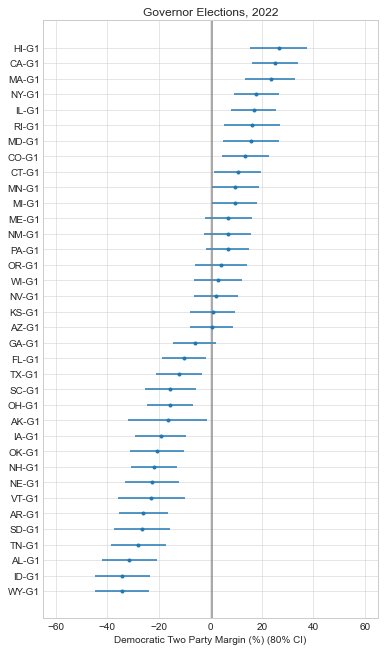

In [18]:
govplot = gov_top.copy()
govplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
govplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
govplot = govplot.sort_values(by='mean_netpartymargin', ascending=True)
govplot.reset_index(drop=True, inplace=True)
m.seatplot(
    govplot,
    x='mean_netpartymargin',
    y='district',
    title='Governor Elections, 2022',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/govseats.png'
)

# State Legislatures

In [19]:
j_categories = pd.read_csv('./data/output/jacobson_category_summary.csv')
j_categories.rename(
    columns={'jacobsonforecast': 'forecast', 'mean': 'dem_seatshare'},
    inplace=True
)
j_categories

,jacobsonforecastnumeric,forecast,dem_seatshare,std,pr_close,CI80_lower,CI80_upper
0,1.0,Safe R,28.697171,9.083162,0.003717,15.991489,40.322580
1,2.0,Likely R,38.826987,6.436138,0.018692,30.000000,45.900000
2,3.0,Lean R,42.848929,6.444749,0.139535,35.676768,50.633354
3,4.0,Toss-up,50.385232,6.223403,0.378049,41.666667,58.192256
4,5.0,Lean D,55.589494,5.377861,0.213115,49.253731,63.265300
5,6.0,Likely D,58.606672,5.866417,0.053571,51.931926,64.857145
6,7.0,Safe D,72.247156,10.883517,0.004854,60.000000,87.500000


In [20]:
state_forecasts = s.get_jacobson(
    save_loc='./data/jacobson/',
    archive_loc='./data/archive/'
)
# Inner join removes states without elections
state_forecasts = state_forecasts.merge(j_categories, on='forecast')
state_forecasts = state_forecasts.merge(state_converter[['state','state_abbr']], on='state')
state_forecasts

Accessed:  https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/


,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr
0,Alabama,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
1,Alabama,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
2,Arkansas,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
3,Arkansas,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
4,Florida,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,FL
...,...,...,...,...,...,...,...,...,...,...
81,New Mexico,house,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,NM
82,Oregon,house,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,OR
83,Oregon,senate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,OR
84,Maine,house,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME


In [21]:
st_sen = state_forecasts.query('office == "senate"')
st_sen = st_sen.merge(
    power['statesenate_power'][['state', 'potential_power']],
    on='state'
)
st_sen['pr_tip'] = 1
st_sen.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_sen['office'] = 'statesenate'
st_sen.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
19,Michigan,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI,0.757080,1,0.286213
32,New York,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,NY,1.494146,1,0.080044
39,Oregon,statesenate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,OR,0.319843,1,0.068163
20,Minnesota,statesenate,Lean R,3.0,42.848929,6.444749,0.139535,35.676768,50.633354,MN,0.429911,1,0.059988
37,Illinois,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
38,Nevada,statesenate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,NV,0.236822,1,0.050470
40,Maine,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
2,Florida,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,FL,1.640670,1,0.030667
26,Pennsylvania,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,PA,0.976522,1,0.018253
22,Georgia,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,GA,0.813481,1,0.015205


In [22]:
st_sen['realized_power'].sum()

0.7998744384448527

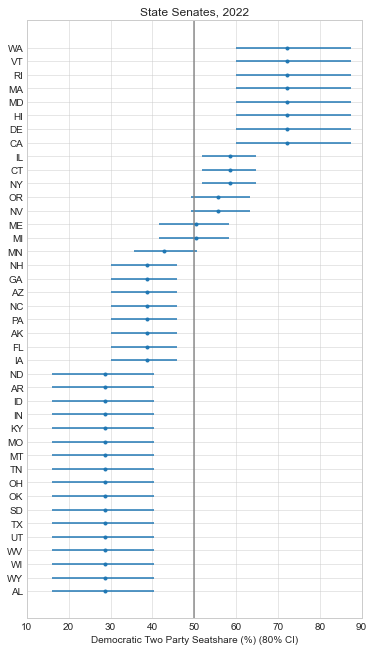

In [23]:
stsen_plot = st_sen.copy()
stsen_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
stsen_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
stsen_plot = stsen_plot.sort_values(by='dem_seatshare', ascending=True)
stsen_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    stsen_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Senates, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90), 
    midpoint=50,
    out='data/output/statesenateseats.png'
)

In [24]:
st_hs = state_forecasts.query('office == "house"')
st_hs = st_hs.merge(
    power['statehouse_power'][['state', 'potential_power']],
    on='state'
)
st_hs['pr_tip'] = 1
st_hs.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_hs['office'] = 'statehouse'
st_hs.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
22,Minnesota,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MN,0.429911,1,0.162527
21,Michigan,statehouse,Lean R,3.0,42.848929,6.444749,0.139535,35.676768,50.633354,MI,0.757080,1,0.105639
40,Illinois,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
44,Maine,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
38,Colorado,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CO,0.437796,1,0.023453
28,Pennsylvania,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,PA,0.976522,1,0.018253
43,Oregon,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,OR,0.319843,1,0.017134
24,Georgia,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,GA,0.813481,1,0.015205
27,North Carolina,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,NC,0.794770,1,0.014856
39,Connecticut,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CT,0.271593,1,0.014550


In [25]:
st_hs['realized_power'].sum()

0.5766057154064279

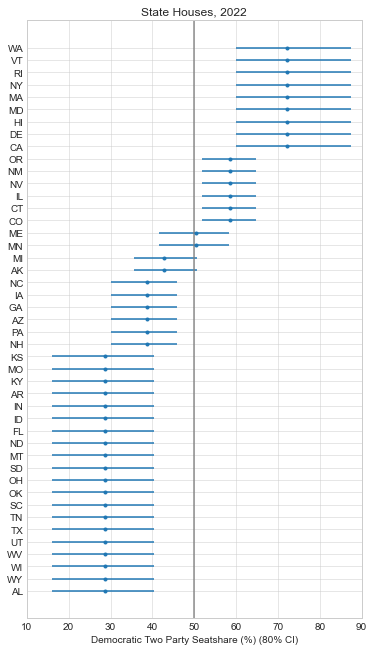

In [26]:
sths_plot = st_hs.copy()
sths_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
sths_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
sths_plot = sths_plot.sort_values(by='dem_seatshare', ascending=True)
sths_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    sths_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Houses, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90),
    midpoint=50,
    out='data/output/statehouseseats.png'
)

# Cumulative Results

In [27]:
# Relabel and standardise data for combination, output
out_cols = [
    'branch', 'district', 'state_abbr', 'forecast_measure',
    'forecast', 'ci_low', 'ci_high', 'ci_measure', 'potential_power',
    'pr_close', 'pr_tip', 'realized_power'
]

final_dfs = []

for df in [sen_top, hs_top, gov_top]:
    df = df.copy()
    df['forecast_measure'] = 'net_dem_twoparty_margin'
    df['ci_measure'] = '80pct'
    df.rename(
        columns={
            'tipping':'pr_tip',
            'mean_netpartymargin': 'forecast',
            'p10_netpartymargin': 'ci_low',
            'p90_netpartymargin': 'ci_high',
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
for df in [st_sen, st_hs]:
    df = df.copy()
    df['forecast_measure'] = 'dem_twoparty_seatshare'
    df['ci_measure'] = '80pct'
    df['district'] = df['state_abbr']
    del df['forecast']
    df.rename(
        columns={
            'dem_seatshare': 'forecast',
            'CI80_lower': 'ci_low',
            'CI80_upper': 'ci_high',
            'office':'branch'
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
cumulative_df = pd.concat(final_dfs)
cumulative_df = cumulative_df.sort_values(
    by='realized_power',
    ascending=False
).reset_index(drop=True)
cumulative_df.to_csv('data/output/all_elections.csv', index=False)
cumulative_df.head(50)

,branch,district,state_abbr,forecast_measure,forecast,ci_low,ci_high,ci_measure,potential_power,pr_close,pr_tip,realized_power
0,ussenate,GA-S3,GA,net_dem_twoparty_margin,0.774178,-7.416113,8.980309,80pct,25.000000,0.641325,0.154388,2.475314
1,ussenate,NV-S3,NV,net_dem_twoparty_margin,2.102226,-7.155506,11.383720,80pct,25.000000,0.641325,0.135763,2.176697
2,ussenate,WI-S3,WI,net_dem_twoparty_margin,-0.453033,-9.724136,8.839512,80pct,25.000000,0.641325,0.124262,1.992316
3,ussenate,AZ-S3,AZ,net_dem_twoparty_margin,4.885197,-4.307312,14.116590,80pct,25.000000,0.641325,0.109125,1.749615
4,ussenate,NC-S3,NC,net_dem_twoparty_margin,-2.307522,-11.271270,6.617327,80pct,25.000000,0.641325,0.101475,1.626961
5,ussenate,PA-S3,PA,net_dem_twoparty_margin,5.633774,-3.429310,14.661830,80pct,25.000000,0.641325,0.096613,1.549000
6,ussenate,NH-S3,NH,net_dem_twoparty_margin,6.227501,-3.840082,16.107360,80pct,25.000000,0.641325,0.085013,1.363016
7,ussenate,OH-S3,OH,net_dem_twoparty_margin,-4.593002,-14.080200,4.853119,80pct,25.000000,0.641325,0.066975,1.073819
8,ussenate,CO-S3,CO,net_dem_twoparty_margin,9.365784,-0.272493,18.860590,80pct,25.000000,0.641325,0.044925,0.720288
9,governor,PA-G1,PA,net_dem_twoparty_margin,6.622093,-1.586126,14.841460,80pct,3.906086,0.182737,1.000000,0.713786


In [28]:
matrix = cumulative_df.groupby(by=['state_abbr', 'branch']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state_abbr', columns='branch', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
matrix.to_csv('data/output/statescore-matrix.csv', index=True)

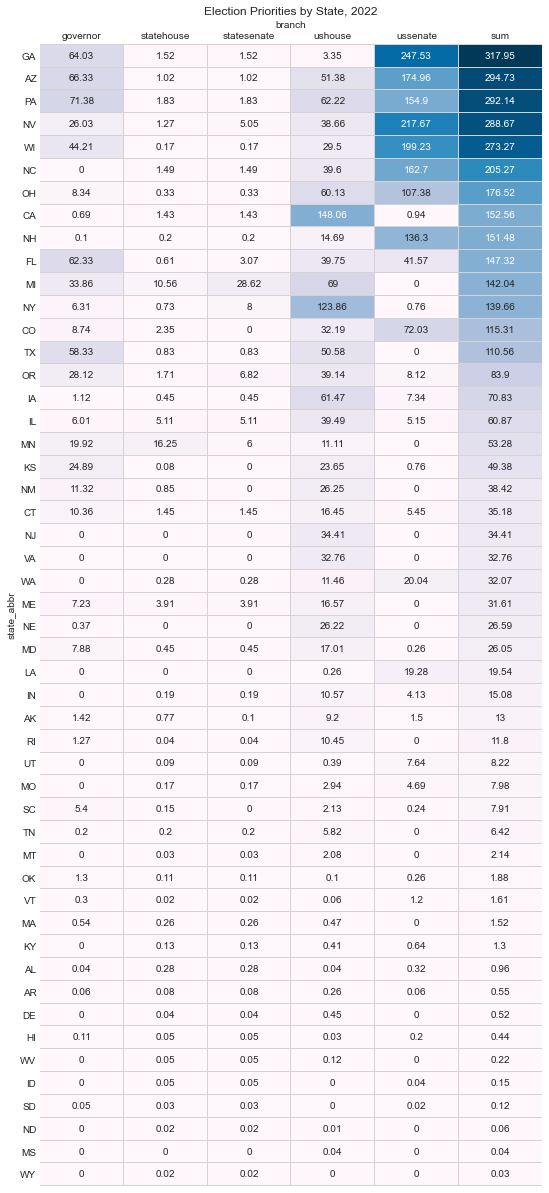

In [29]:
#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[9,21]) #[9, 20] [7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(matrix, decimals=2),
    ax=ax, annot=True, fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=False, cmap='PuBu') 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
plt.title('Election Priorities by State, 2022')
plt.savefig('../heatmap.png', bbox_inches='tight')
heatmap

In [30]:
# Just do manual summary of funds below, because getting data summarized
# at the federal House/Senate level is difficult from Open Secrets, and their API
# only allows per candidate queries. 
# state_funding = s.get_followthemoney(
#     save_loc='./data/funding/',
#     archive_loc='./data/archive/'
# )
# def match_branch(el):
#     matches = {
#         'Gubernatorial': 'governor',
#         'State House/Assembly': 'statehouse',
#         'State Senate': 'statesenate'
#     }
#     return matches[el]

# office_list = ['Gubernatorial', 'State House/Assembly', 'State Senate']
# state_funding = state_funding.query('General_Office.isin(@office_list)')
# state_funding['branch'] = state_funding['General_Office'].apply(match_branch)
# state_funding.rename(
#     columns={'Election_Jurisdiction':'state_abbr', 'Total_$':'funding'},
#     inplace=True
# )
# state_funding = state_funding[['state_abbr', 'funding', 'branch']]
# state_funding

In [33]:
summary_df = cumulative_df.groupby(
    by='branch'
).agg(
    {'realized_power':'sum'}
).sort_values(
    by='realized_power',
    ascending=False
)
summary_df.reset_index(drop=False, inplace=True)

# State Legislative funding:
# https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
# https://www.opensecrets.org/news/2022/03/a-behind-the-scenes-look-at-collecting-state-campaign-finance-data-in-2022/
# By state and office: https://www.followthemoney.org/show-me#[{1|gro=y,c-r-ot,s
# Federal data:
# https://www.fec.gov/data/raising-bythenumbers/
# https://www.opensecrets.org/elections-overview
funding = pd.DataFrame({
    'branch': ['ussenate', 'ushouse', 'governor', 'statesenate', 'statehouse'],
    'funding': [1048957205, 1437833500, 1286789363, 285562609, 449290793]
})
summary_df = summary_df.merge(funding, on='branch')
summary_df.eval('power_pct = 100*realized_power/realized_power.sum()', inplace=True)

summary_df.eval('funding_pct = 100*funding/funding.sum()', inplace=True)
#del summary_df['funding']
summary_df.eval('funding_gap = power_pct - funding_pct', inplace=True)
print('https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y')
print('https://www.fec.gov/data/raising-bythenumbers/')

summary_df.set_index('branch', inplace=True)

summary_df = summary_df.style.format({
    "realized_power": "{:.1f}",
    "power_pct": "{:.1f}",
    "funding_pct": "{:.1f}",
    "funding_gap": "{:.1f}",
    "funding": "{:20,.2f}"
}).background_gradient(
    #subset=['power_pct', 'funding_pct', 'funding_gap']
)
m.output_table(summary_df, './data/output/power_frac.html')
summary_df

https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
https://www.fec.gov/data/raising-bythenumbers/


,realized_power,funding,power_pct,funding_pct,funding_gap
branch,,,,,
ussenate,16.0,"1,048,957,205.00",46.0,23.3,22.7
ushouse,11.6,"1,437,833,500.00",33.4,31.9,1.5
governor,5.8,"1,286,789,363.00",16.6,28.5,-11.9
statesenate,0.8,"285,562,609.00",2.3,6.3,-4.0
statehouse,0.6,"449,290,793.00",1.7,10.0,-8.3


In [35]:
# Output
# !cp -vr data/output/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta-2022